In [1]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [4]:
featstats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean')

In [11]:
# simple first glimpse
year_list = np.arange(2001,2020)
BL_sum = []
duration_sum = []
for year in year_list:
    data = xr.open_dataset(featstats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
    BL_sum.extend(340*3/9.81*data.BL_TOT_amean.sel(mcs_phase=['Init','Grow','Mature']).mean('mcs_phase').values)
    duration_sum.extend(data.mcs_duration)

In [14]:
def get_bins_samples_BLmean(var_name, factor, bins_duration, bins_BL):
       
    bins_samples = np.zeros((len(bins_BL)-1, len(bins_duration)-1))

    year_list = np.arange(2001,2020)
    for year in year_list:

        data = xr.open_dataset(featstats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
        BL_1d = factor*data[var_name].sel(mcs_phase=['Init','Grow','Mature']).mean('mcs_phase').values.ravel()
        BL_duration_1d = data.mcs_duration.values.ravel()

        for i in range(len(bins_BL)-1):
            idx = np.where(np.logical_and(BL_1d >= bins_BL[i] , BL_1d < bins_BL[i+1]))[0]
            for j in range(len(bins_duration)-1):
                idy = np.where(np.logical_and(BL_duration_1d >= bins_duration[j] , BL_duration_1d < bins_duration[j+1]))[0]
                idx_com = np.intersect1d(idx,idy)
                bins_samples[i,j] += len(idx_com)
                
    # save as xarray dataset
    bins_samples_xr = xr.Dataset(data_vars=dict(samples=(['bins_BL','bins_duration'], bins_samples)),
                                 coords=dict(bins_BL=(['bins_BL'], bins_BL[:-1]),
                                             bins_duration=(['bins_duration'],bins_duration[:-1])))
    
    return bins_samples_xr

In [18]:
def get_bins_samples(var_name, factor, mcs_phase, bins_duration, bins_BL):
       
    bins_samples = np.zeros((len(bins_BL)-1, len(bins_duration)-1))

    year_list = np.arange(2001,2020)
    for year in year_list:

        data = xr.open_dataset(featstats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
        BL_1d = factor*data[var_name].sel(mcs_phase=mcs_phase).values.ravel()
        BL_duration_1d = data.mcs_duration.values.ravel()

        for i in range(len(bins_BL)-1):
            idx = np.where(np.logical_and(BL_1d >= bins_BL[i] , BL_1d < bins_BL[i+1]))[0]
            for j in range(len(bins_duration)-1):
                idy = np.where(np.logical_and(BL_duration_1d >= bins_duration[j] , BL_duration_1d < bins_duration[j+1]))[0]
                idx_com = np.intersect1d(idx,idy)
                bins_samples[i,j] += len(idx_com)
                
    # save as xarray dataset
    bins_samples_xr = xr.Dataset(data_vars=dict(samples=(['bins_BL','bins_duration'], bins_samples)),
                                 coords=dict(bins_BL=(['bins_BL'], bins_BL[:-1]),
                                             bins_duration=(['bins_duration'],bins_duration[:-1])))
    
    return bins_samples_xr

In [19]:
def plot_bins_samples(bins_samples_xr, title):
    
    fig, ax = plt.subplots(1,1,figsize=(5,3.5))

    bins_samples = bins_samples_xr.samples.values
    bins_BL = bins_samples_xr.bins_BL
    bins_duration = bins_samples_xr.bins_duration
    
    margin_prob = np.zeros(bins_samples.shape)
    duration_cond = np.zeros(bins_samples.shape[0])
    for i in range(bins_samples.shape[0]):
        margin_prob[i,:] = bins_samples[i,:]/np.sum(bins_samples[i,:])
    for i in range(bins_samples.shape[0]):
        duration_cond[i] = np.sum(bins_duration*margin_prob[i,:])

    BL_samples = np.sum(bins_samples, axis=1)
        
    cp = ax.pcolormesh(bins_BL, bins_duration, margin_prob.T, vmin=0.0001, vmax=0.2, cmap='jet')
    cp.cmap.set_under('w')
    cbar = plt.colorbar(cp,ax=ax,extend='min', pad=0.2, shrink=0.8)
    cbar.set_label('Probability|$_{B_{L,init}}$',fontsize=10)
    ax.plot(bins_BL, duration_cond, color='m', zorder=2, lw=2)
    ax2 = ax.twinx()
    ax2.plot(bins_BL, BL_samples, color='grey', zorder=2)

    ax.set_xlabel('B$_{L,init.}$ (m/s^2)',fontsize=10.5)
    ax.set_ylabel('MCS durattion (hour)',fontsize=10.5)
    ax2.set_ylabel('Samples',fontsize=10.5, color='k')
    #ax.set_xlim([-0.1,0.01])
    ax.set_ylim([5,80])
    ax2.set_ylim(ymin = 0)

    ax.tick_params(labelsize=9)
    ax2.tick_params(labelsize=9)   
    ax.set_title(title, fontsize=10)

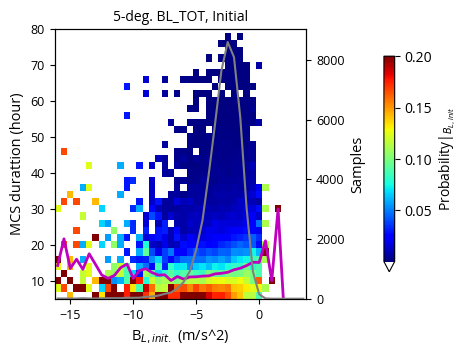

In [26]:
# BL,tot Inital phase
bins_samples_TOT = get_bins_samples(var_name='BL_TOT_amean', factor=340*3/9.81, mcs_phase='Init',
                        bins_duration = np.linspace(0,80,41), bins_BL = np.linspace(-16,4,41))
plot_bins_samples(bins_samples_TOT, title='5-deg. BL_TOT, Initial')

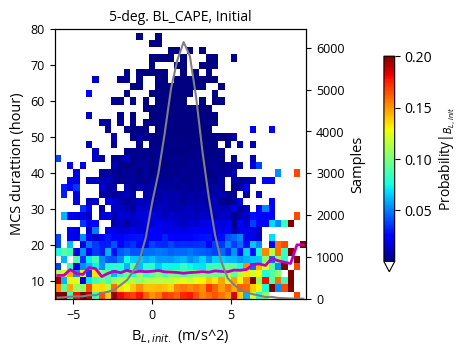

In [27]:
# BL,CAPE Inital phase
bins_samples_CAPE = get_bins_samples(var_name='BL_CAPE_amean', factor=(340*3)/9.81/0.4, mcs_phase='Init',
                        bins_duration = np.linspace(0,80,41), bins_BL = np.linspace(-6,10,41))
plot_bins_samples(bins_samples_CAPE, title='5-deg. BL_CAPE, Initial')

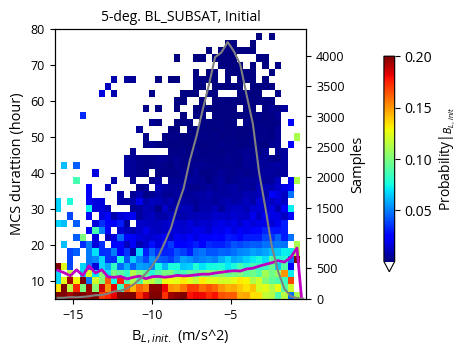

In [28]:
# BL,SUBSAT Inital phase
bins_samples_SUBSAT = get_bins_samples(var_name='BL_SUBSAT_amean', factor=-(340*3)/9.81/0.6, mcs_phase='Init',
                        bins_duration = np.linspace(0,80,41), bins_BL = np.linspace(-16,0,41))
plot_bins_samples(bins_samples_SUBSAT, title='5-deg. BL_SUBSAT, Initial')

In [ ]:
# BL,SUBSAT Grow phase
bins_samples_CAPE = get_bins_samples(var_name='BL_SUBSAT_amean', factor=-(340*3)/9.81/0.6, mcs_phase='Mature',
                        bins_duration = np.linspace(0,80,41), bins_BL = np.linspace(-16,0,41))
plot_bins_samples(bins_samples_CAPE, title='5-deg. BL_SUBSAT, Mature')

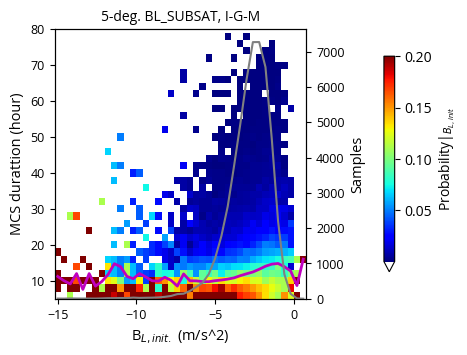

In [24]:
# mean intensity of BL,tot during the developing period (init, grow, mature)
bins_samples_BLmean = get_bins_samples_BLmean(var_name='BL_TOT_amean', factor=(340*3)/9.81,
                        bins_duration = np.linspace(0,80,41), bins_BL = np.linspace(-15,1,41))
plot_bins_samples(bins_samples_BLmean, title='5-deg. BL_SUBSAT, I-G-M')